# GMMによるクラスタリング

https://datachemeng.com/gaussianmixturemodel/ 

↑わかりやすいです

実は、K-means法は特徴量間での相関が全くなく、分散が固定であるという仮定の下で行われるGMMといえるらしいです。
より一般化されたK-means法だと思えばよさそう。よって非階層型クラスタリングである。

## クラスタリングは何のため?

クラスタリングは教師なし学習あるといえる。データだけが与えられたがその中身がよくわからない、となった時に利用できる。例えば次が利用対象である。

### パターンの発見

データ内の構造やパターンを発見できる。例えば沢山の顧客データがあった時、顧客のクラスターを見つけることができればそれぞれに適したマーケティング戦略が得られるかもしれない。

### 次元削減

高次元のデータが与えられたとき、クラスタリングを行い、各クラスター間の重心距離が大きいものや、クラスターの中での分散が小さな値は支配的なパラメータとみなすことができる。

**→でも、高次元のデータならそもそも最初のクラスタリングが難しくない? そのためにはどの特徴量に着目すればいいの?**

**→分散が小さい次元を除外したり、主成分分析をしたりといろいろあるらしい　今回は学習の範囲に入れませんが．．．．．．**

### 異常検知

どのクラスターからも外れた値を異常値として検出することができる。製造業などの分野で利用される。

### 機械学習の前処理

画像認識などのタスクにおいて、ラベル付けに利用する。

## そもそもGMM（混合ガウスモデル）ってなんだ?

**複数の正規分布の重ね合わせ**でデータセットの確率密度を推定するモデル(言葉の定義ががばがばです。多分間違っています)

各データ点について、どの正規分布に所属するのか確率密度の高さで求めることができるので、GMMによってクラスタリングできる

## 何がわかればいいの?

コンポーネント数（混合された正規分布の数）が決まっていたとしたら、

- **各コンポーネントの平均ベクトル:** $\boldsymbol{\mu}$
- **各コンポーネント間の分散共分散行列:** $\boldsymbol{\Sigma}$
- **混合係数ベクトル(各コンポーネントの重み):** $\boldsymbol{\pi}$

がわかればモデルを構築することができる。これらのモデルパラメータを最尤推定法で求める必要がある。

最尤推定というのは、パラメータが与えられたデータに最もフィットするように最適化することだと認識している。

## どうやって最尤推定なんてするの? 目的関数はどうするの?

### ＞どうやって最尤推定なんてするの?
**EMアルゴリズム**を使用することが多いらしい

**EMアルゴリズム**というのは　EvaluateメソッドとModifyメソッドを使用してそれぞれ尤度評価、パラメータ更新を何度も繰り返して行うアルゴリズム。

関数形が既知のため、解析的に最適化できる。

### ＞目的関数はどうするの?
**対数尤度関数**を使用することが多いらしい。次式で与えられる。

$N$：データ点数,  $n$：混合成分数,  $N(x_j | \mu_k, \Sigma_k)$：第$k$成分のガウス分布の確率密度関数

$\log L(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma} | \mathbf{X}) = \log \left\{ \prod_{j=1}^{N} \sum_{k=1}^{n} \pi_k N(x_j | \mu_k, \Sigma_k) \right\} = \sum_{j=1}^{N} \log \left\{ \sum_{k=1}^{n} \pi_k N(x_j | \mu_k, \Sigma_k) \right\}$

この値を最大にするように最適化を行う。


## EMアルゴリズムって具体的には何やってんの?

**ラグランジュの未定乗数法**を使うらしい。目的関数が既知(解析的に表現できる)で微分可能かつ、制約条件がある場合(今回は$\boldsymbol{\pi}$の和が1)に使いやすい最適化手法である。

この手法によりEstepの結果がわかれば、Mstepでのパラメータ更新値が一意に計算できる。(下に式を示した)

以前行った最適化チュートリアルのように学習率などの設定は不要である。

$\pi_k^{\text{new}} = \frac{N_k}{N}$

$\mu_k^{\text{new}} = \frac{\sum_{j=1}^{N} \gamma(z_{j,k}) x_j}{N_k}$

$\Sigma_k^{\text{new}} = \frac{1}{N_k} \sum_{j=1}^{N} \gamma(z_{j,k}) \left(x_j - \mu_k^{\text{new}}\right) \left(x_j - \mu_k^{\text{new}}\right)^T$

## 実際にやってみよう！！

式をちゃんと実装している。しかし、scikit-learnというライブラリを使用すれば、2行でこれらの演算を行うことができる。

また、データセットは複数種類のアヤメの花のデータセットを使用しています。がくと花びらの幅と長さでどの品種かを推定できるらしい。

### ライブラリインポート

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

### クラス、メソッドの作製

In [ ]:
class GMMFromScratch:
    def __init__(self, n_components=3, max_iter=10, tol=1e-3, random_state=None):
        """
        Gaussian Mixture Model implementation from scratch using EM algorithm
        
        Parameters:
        - n_components: Number of Gaussian components
        - max_iter: Maximum number of iterations
        - tol: Tolerance for convergence
        - random_state: Random seed for reproducibility

        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        # Parameters to be learned
        self.means_ = None          # Mean vectors for each component
        self.covariances_ = None    # Covariance matrices for each component
        self.weights_ = None        # Mixing coefficients (prior probabilities)
        self.responsibilities_ = None  # Posterior probabilities
        self.prev_means_ = None  # Previous means for convergence check
        self.prev_covariances_ = None  # Previous covariances for convergence check 
        self.prev_weights_ = None  # Previous weights for convergence check
        self.log_likelihood_history = []  # Track convergence
        
    def _initialize_parameters(self, X):
        """
        Initialize parameters for EM algorithm
        """
        n_samples, n_features = X.shape
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Initialize means randomly from data points
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[random_indices].copy()
        
        # Initialize covariances as identity matrices scaled by data variance
        data_variance = np.var(X, axis=0)
        self.covariances_ = np.array([np.diag(data_variance) for _ in range(self.n_components)])
        
        # Initialize weights uniformly
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        print("Initial parameters:")
        print(f"Means: {self.means_}")
        print(f"Weights: {self.weights_}")
        print("-" * 50)
    
    def _e_step(self, X):
        """
        E-step: Calculate responsibilities (posterior probabilities)
        """
        n_samples = X.shape[0] # 150 * 3
        self.responsibilities_ = np.zeros((n_samples, self.n_components)) # 150 * 3
        
        # Calculate likelihood for each component
        for k in range(self.n_components):
            likelihood = multivariate_normal.pdf(X, self.means_[k], self.covariances_[k]) # 150 * 1
            self.responsibilities_[:, k] = self.weights_[k] * likelihood
        
        # likelihood before normalization
        total_likelihood = np.sum(self.responsibilities_, axis=1, keepdims=True) # 150 * 1
        
        # Normalize to get posterior probabilities
        self.responsibilities_ /= total_likelihood
        
        # calculalte log likelihood
        log_likelihood = np.sum(np.log(total_likelihood.flatten())) # 1
        
        return log_likelihood
    
    def _m_step(self, X):
        """
        M-step: Update parameters based on responsibilities
        
        """
        # save previous parameters for convergence check
        self.prev_means_ = self.means_
        self.prev_covariances_ = self.covariances_
        self.prev_weights_ = self.weights_

        n_samples, n_features = X.shape # 150, 3

        # Calculate effective number of points for each component
        N_k = np.sum(self.responsibilities_, axis=0) # 1 * 3
        
        # Update weights (mixing coefficients)
        # responsibilities_ are already normalized
        self.weights_ = N_k / n_samples # 1 * 3
        
        # Update means
        for k in range(self.n_components):
            self.means_[k] = np.sum(self.responsibilities_[:, k:k+1] * X, axis=0) / N_k[k]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = self.responsibilities_[:, k:k+1] * diff
            self.covariances_[k] = np.dot(weighted_diff.T, diff) / N_k[k]
            
            # avoid singular matrices
            self.covariances_[k] += np.eye(n_features) * 1e-5
    
    def fit(self, X):
        """
        Fit the GMM model using EM algorithm
        """
        print("=== GMM Learning Process ===")
        print(f"Data shape: {X.shape}")
        print(f"Number of components: {self.n_components}")
        print("=" * 50)
        
        # Initialize parameters
        self._initialize_parameters(X)
        log_likelihood = self._e_step(X)
        # Initialize log-likelihood for convergence check
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):

            # M-step
            self._m_step(X)

            # E-step
            log_likelihood = self._e_step(X)
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged after {iteration + 1} iterations")
                break
            
            # Print progress every 10 iterations
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.4f}")
            
            self.log_likelihood_history.append(log_likelihood)
            prev_log_likelihood = log_likelihood
        
        print(f"Final log-likelihood: {log_likelihood:.4f}")
        return self
    
    def predict(self, X):
        """
        Predict cluster labels for new data
        """
        self._e_step(X)
        return np.argmax(self.responsibilities_, axis=1)
    
    def predict_proba(self, X):
        """
        Predict posterior probabilities for new data
        """
        self._e_step(X)
        return self.responsibilities_
    
    def score_samples(self, X):
        """
        Calculate log probability density for each sample
        """
        n_samples = X.shape[0]
        log_prob = np.zeros(n_samples)
        
        for k in range(self.n_components):
            likelihood = multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])
            log_prob += self.weights_[k] * likelihood
        
        return np.log(log_prob)
    
    def fit_multi_init(self, X, n_init=1):
        """
        Fit GMM with multiple random initializations and choose the best result.
        """
        best_log_likelihood = -np.inf
        best_params = None
        best_history = None

        for seed in range(n_init):
            self.random_state = seed
            self._initialize_parameters(X)
            self.log_likelihood_history = []
            prev_log_likelihood = -np.inf
            log_likelihood = self._e_step(X)

            for iteration in range(self.max_iter):
                self._m_step(X)
                log_likelihood = self._e_step(X)
                self.log_likelihood_history.append(log_likelihood)
                if abs(log_likelihood - prev_log_likelihood) < self.tol:
                    break
                prev_log_likelihood = log_likelihood

            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_params = (self.means_.copy(), self.covariances_.copy(), self.weights_.copy())
                best_history = self.log_likelihood_history.copy()

        # Set the best parameters
        self.means_, self.covariances_, self.weights_ = best_params
        self.log_likelihood_history = best_history
        print(f"Best log-likelihood after {n_init} initializations: {best_log_likelihood:.4f}")
        return self

### 一つの初期値から始めるパターンを実行してみる

Training Custom GMM...
=== GMM Learning Process ===
Data shape: (150, 2)
Number of components: 3
Initial parameters:
Means: [[4.7 1.2]
 [1.7 0.3]
 [6.9 2.3]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Iteration 10: Log-likelihood = -136.8845
Iteration 20: Log-likelihood = -136.7183
Iteration 30: Log-likelihood = -136.6337
Iteration 40: Log-likelihood = -136.5922
Converged after 48 iterations
Final log-likelihood: -136.5798


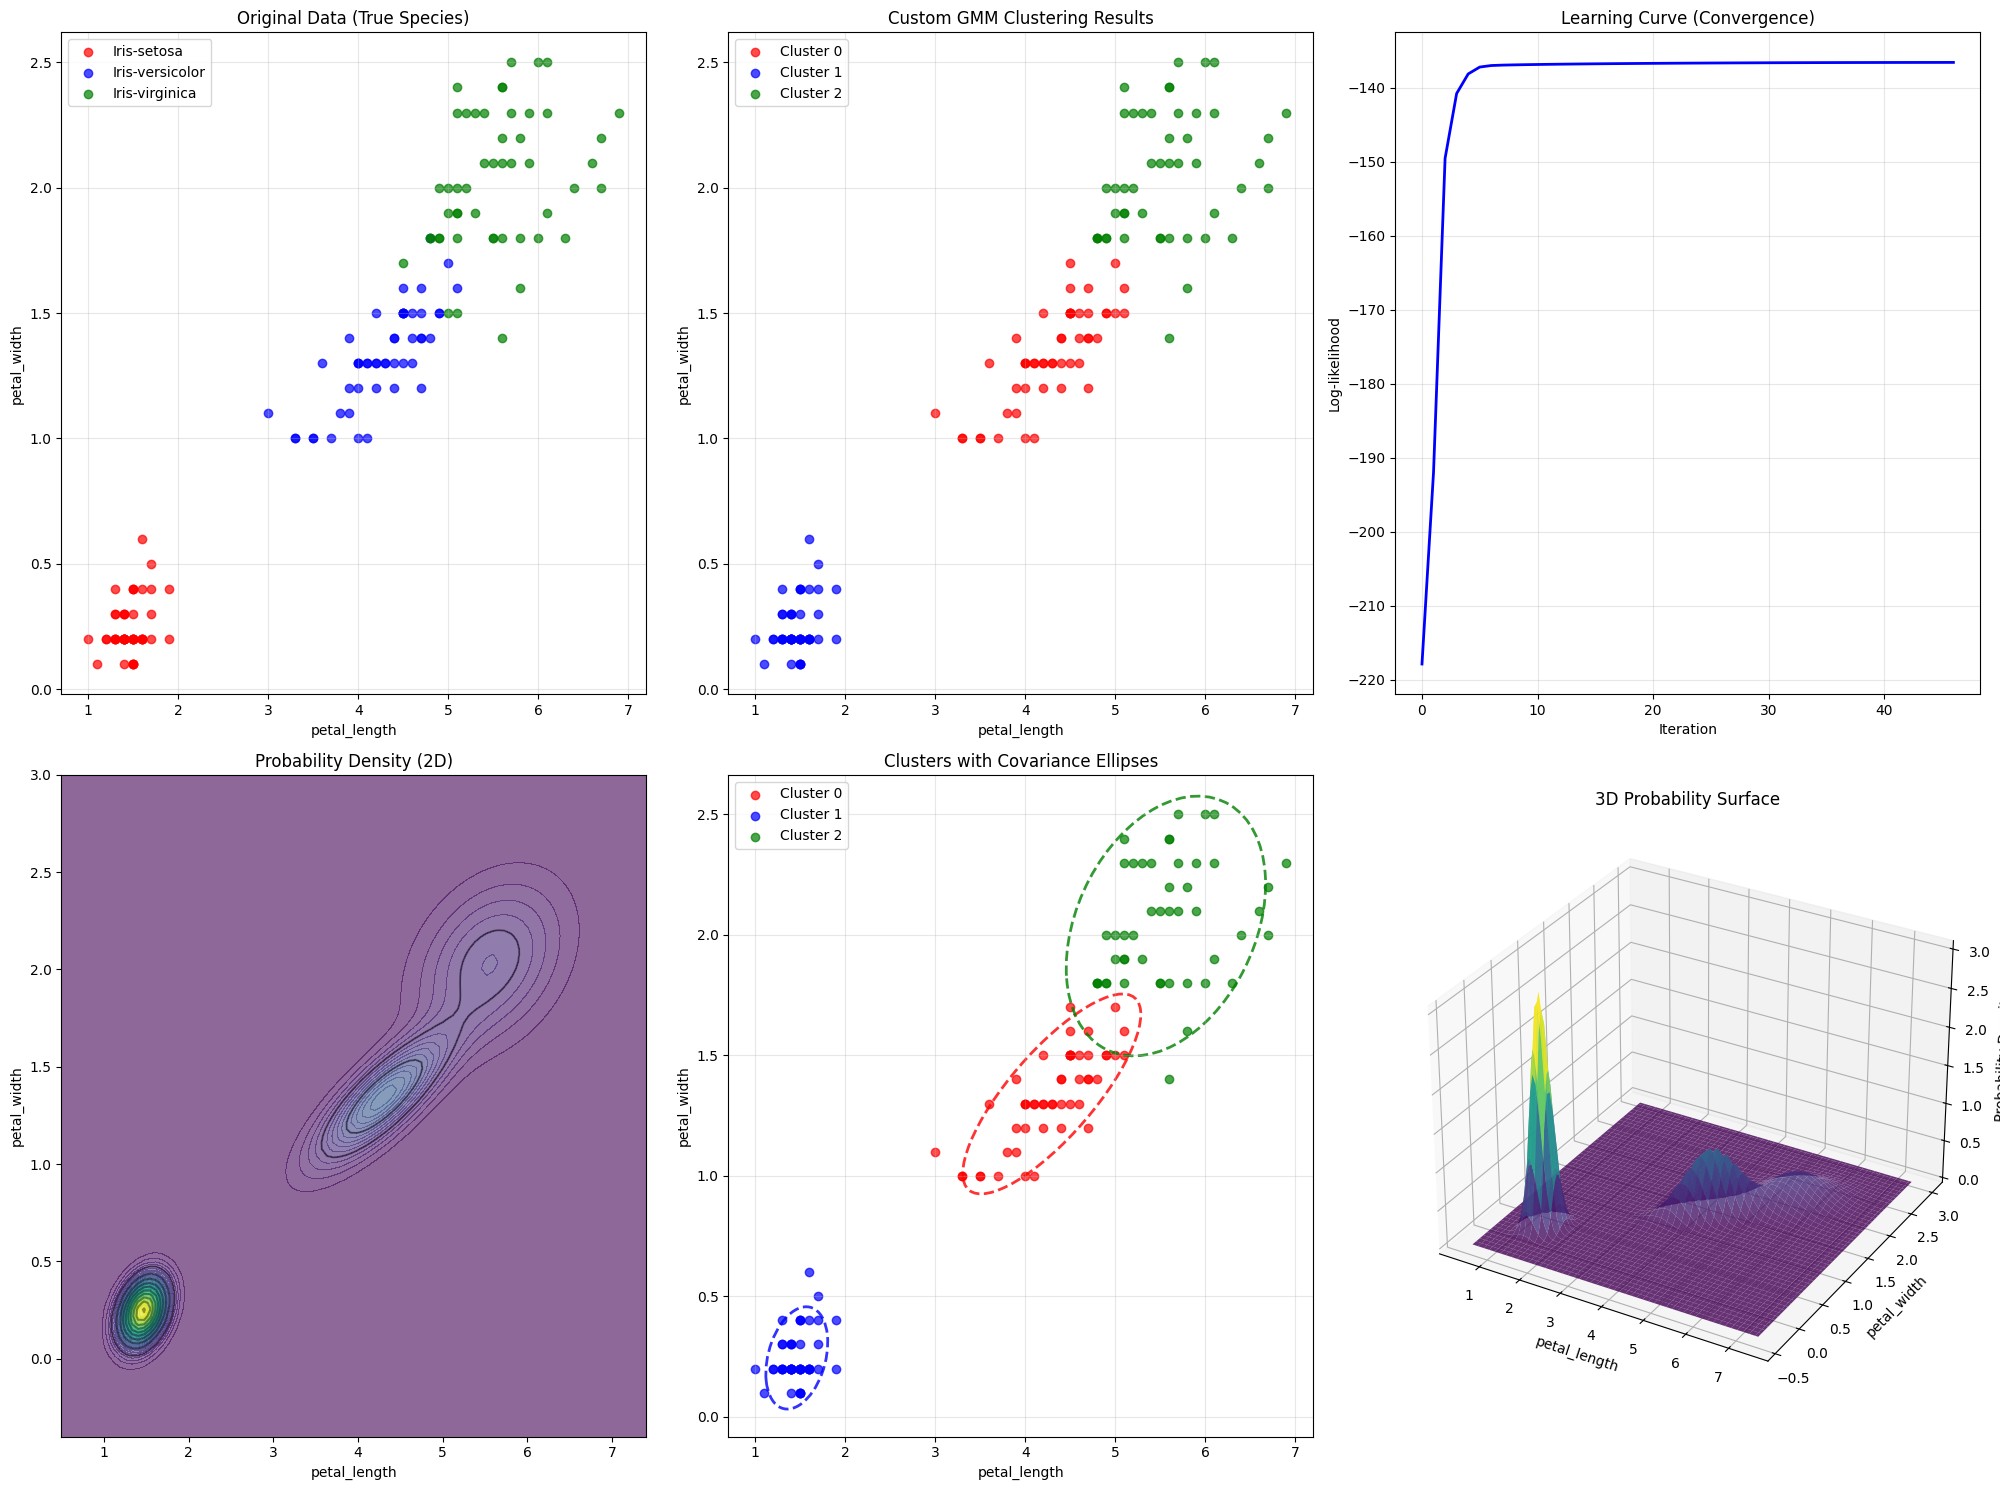


=== Final GMM Parameters ===
Learned Means:
  Component 0: [4.295, 1.340]
  Component 1: [1.464, 0.244]
  Component 2: [5.562, 2.037]

Learned Weights:
  Component 0: 0.345
  Component 1: 0.333
  Component 2: 0.322

Learned Covariances:
  Component 0:
    [[0.244, 0.082]
     [0.082, 0.043]]
  Component 1:
    [[0.030, 0.006]
     [0.006, 0.011]]
  Component 2:
    [[0.306, 0.048]
     [0.048, 0.073]]

=== Comparison with sklearn ===
Custom GMM final log-likelihood: -136.58072003020956

=== True Species vs Custom GMM Clusters ===
Predicted Cluster   0   1   2
True Species                 
Iris-setosa         0  50   0
Iris-versicolor    49   0   1
Iris-virginica      3   0  47


In [22]:
# Load and prepare data
df = pd.read_csv('Iris_dataset.csv')
X = df[['petal_length', 'petal_width']].values #←花びら(petal)についてのみデータを読み込んでいます変えてみると発見があるかも。
feature_names = ['petal_length', 'petal_width']

# Create and train custom GMM
print("Training Custom GMM...")
custom_gmm = GMMFromScratch(n_components=3, random_state=42, max_iter=1000) #←乱数シード値は42にされることが慣例らしいです。変えてみると結果が変わります。
custom_gmm.fit(X)

# Get predictions
cluster_labels = custom_gmm.predict(X)
cluster_probs = custom_gmm.predict_proba(X)

# Create visualization
fig = plt.figure(figsize=(20, 15))

# 1. Original data
ax1 = fig.add_subplot(2, 3, 1)
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
df['species_num'] = df['species'].map(species_mapping)
colors = ['red', 'blue', 'green']
species_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

for i, (color, species) in enumerate(zip(colors, species_names)):
    mask = df['species_num'] == i
    ax1.scatter(X[mask, 0], X[mask, 1], c=color, alpha=0.7, label=species)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_title('Original Data (True Species)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Custom GMM results
ax2 = fig.add_subplot(2, 3, 2)
for i in range(3):
    mask = cluster_labels == i
    ax2.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')
ax2.set_xlabel(feature_names[0])
ax2.set_ylabel(feature_names[1])
ax2.set_title('Custom GMM Clustering Results')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning curve
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(custom_gmm.log_likelihood_history, 'b-', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log-likelihood')
ax3.set_title('Learning Curve (Convergence)')
ax3.grid(True, alpha=0.3)

# 4. Probability density with contours
ax4 = fig.add_subplot(2, 3, 4)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
log_prob = custom_gmm.score_samples(grid_points)
prob = np.exp(log_prob)
prob = prob.reshape(xx.shape)

contour = ax4.contour(xx, yy, prob, levels=10, colors='black', alpha=0.4)
ax4.contourf(xx, yy, prob, levels=50, cmap='viridis', alpha=0.6)
ax4.set_xlabel(feature_names[0])
ax4.set_ylabel(feature_names[1])
ax4.set_title('Probability Density (2D)')

# 5. Covariance ellipses
ax5 = fig.add_subplot(2, 3, 5)
for i in range(3):
    mask = cluster_labels == i
    ax5.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')

# Draw ellipses for each component
for i in range(custom_gmm.n_components):
    mean = custom_gmm.means_[i]
    cov = custom_gmm.covariances_[i]
    
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width = 2 * np.sqrt(eigenvals[0]) * 2
    height = 2 * np.sqrt(eigenvals[1]) * 2
    
    ellipse = Ellipse(mean, width, height, angle=angle, 
                     facecolor='none', edgecolor=colors[i], 
                     linewidth=2, linestyle='--', alpha=0.8)
    ax5.add_patch(ellipse)

ax5.set_xlabel(feature_names[0])
ax5.set_ylabel(feature_names[1])
ax5.set_title('Clusters with Covariance Ellipses')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 3D probability surface
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
surf = ax6.plot_surface(xx, yy, prob, cmap='viridis', alpha=0.8)
ax6.set_xlabel(feature_names[0])
ax6.set_ylabel(feature_names[1])
ax6.set_zlabel('Probability Density')
ax6.set_title('3D Probability Surface')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n=== Final GMM Parameters ===")
print("Learned Means:")
for i, mean in enumerate(custom_gmm.means_):
    print(f"  Component {i}: [{mean[0]:.3f}, {mean[1]:.3f}]")

print("\nLearned Weights:")
for i, weight in enumerate(custom_gmm.weights_):
    print(f"  Component {i}: {weight:.3f}")

print("\nLearned Covariances:")
for i, cov in enumerate(custom_gmm.covariances_):
    print(f"  Component {i}:")
    print(f"    [[{cov[0,0]:.3f}, {cov[0,1]:.3f}]")
    print(f"     [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]")

# Compare with sklearn results

print("\n=== Comparison with sklearn ===")
print("Custom GMM final log-likelihood:", custom_gmm.log_likelihood_history[-1])

# Confusion matrix
comparison = pd.crosstab(df['species'], cluster_labels, 
                        rownames=['True Species'], colnames=['Predicted Cluster'])
print("\n=== True Species vs Custom GMM Clusters ===")
print(comparison)

### 複数の初期値から始めて良いパターンを探す方法で実行してみる

Training Custom GMM...
Initial parameters:
Means: [[5.1 2.4]
 [4.  1. ]
 [1.4 0.2]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[1.2 0.2]
 [3.  1.1]
 [4.4 1.4]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[1.4 0.3]
 [1.5 0.2]
 [5.  2. ]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[1.4 0.2]
 [1.5 0.2]
 [1.5 0.4]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[5.6 2.1]
 [1.7 0.3]
 [6.1 1.9]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[3.9 1.2]
 [5.6 1.4]
 [5.1 2.4]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[1.4 0.2]
 [5

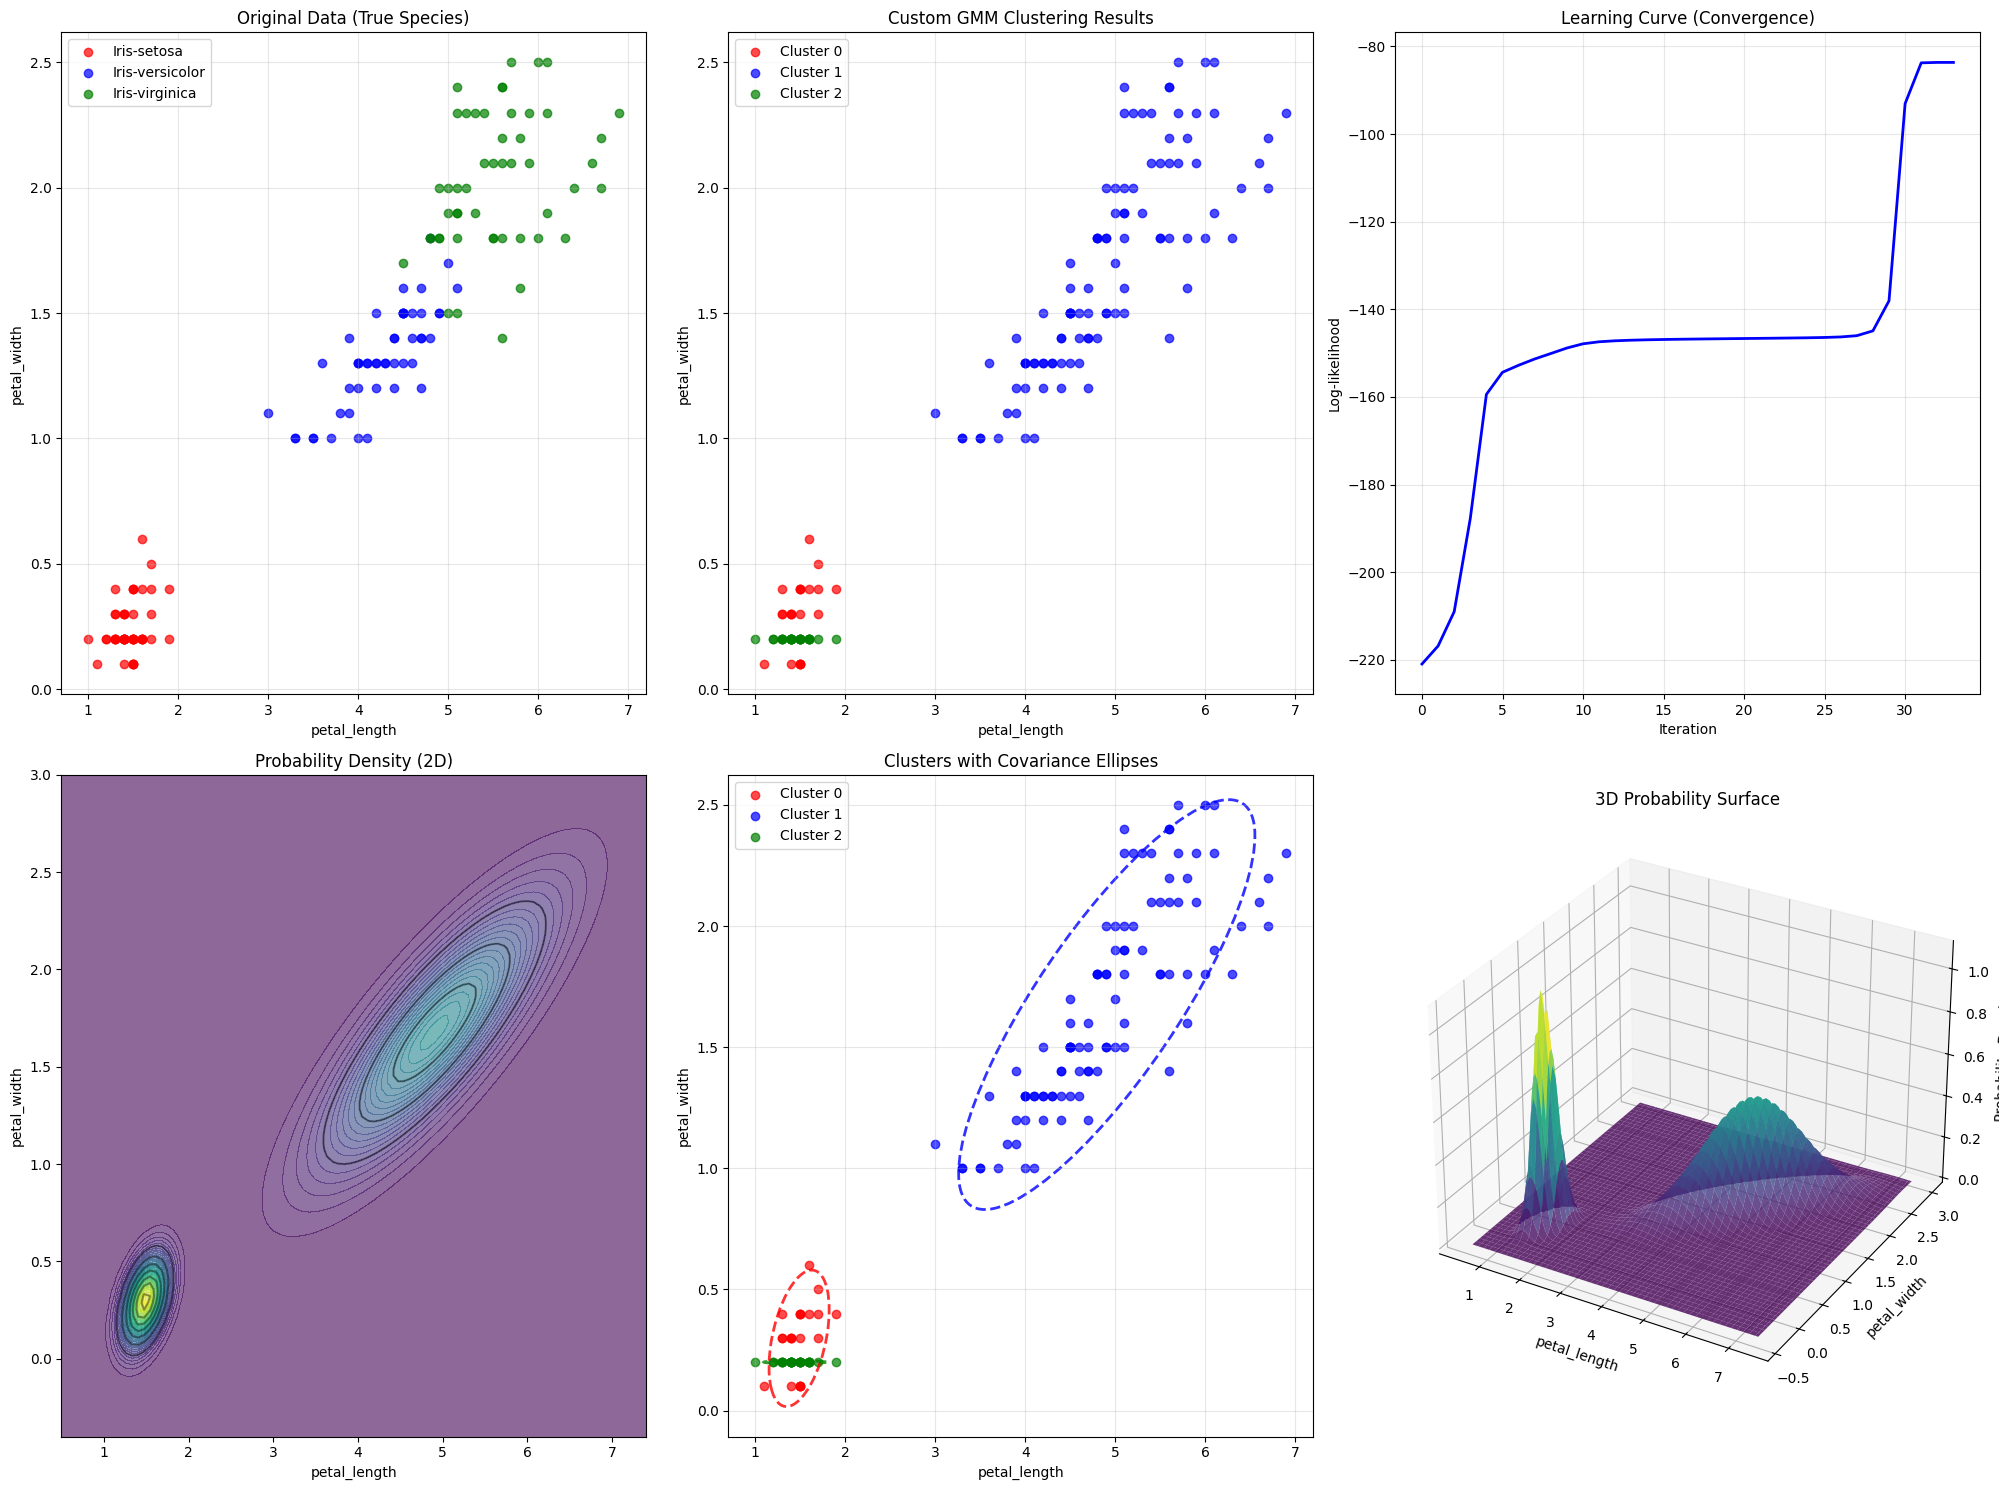


=== Final GMM Parameters ===
Learned Means:
  Component 0: [1.490, 0.298]
  Component 1: [4.905, 1.676]
  Component 2: [1.443, 0.200]

Learned Weights:
  Component 0: 0.149
  Component 1: 0.667
  Component 2: 0.184

Learned Covariances:
  Component 0:
    [[0.028, 0.010]
     [0.010, 0.020]]
  Component 1:
    [[0.676, 0.287]
     [0.287, 0.179]]
  Component 2:
    [[0.030, 0.000]
     [0.000, 0.000]]

=== Comparison with sklearn ===
Custom GMM final log-likelihood: -83.66315028085397

=== True Species vs Custom GMM Clusters ===
Predicted Cluster   0   1   2
True Species                 
Iris-setosa        22   0  28
Iris-versicolor     0  50   0
Iris-virginica      0  50   0


In [23]:
# Load and prepare data
df = pd.read_csv('Iris_dataset.csv')
X = df[['petal_length', 'petal_width']].values
feature_names = ['petal_length', 'petal_width']

# Create and train custom GMM
print("Training Custom GMM...")
custom_gmm = GMMFromScratch(n_components=3, random_state=42, max_iter=1000)
custom_gmm.fit_multi_init(X, n_init=10)

# Get predictions
cluster_labels = custom_gmm.predict(X)
cluster_probs = custom_gmm.predict_proba(X)

# Create visualization
fig = plt.figure(figsize=(20, 15))

# 1. Original data
ax1 = fig.add_subplot(2, 3, 1)
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
df['species_num'] = df['species'].map(species_mapping)
colors = ['red', 'blue', 'green']
species_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

for i, (color, species) in enumerate(zip(colors, species_names)):
    mask = df['species_num'] == i
    ax1.scatter(X[mask, 0], X[mask, 1], c=color, alpha=0.7, label=species)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_title('Original Data (True Species)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Custom GMM results
ax2 = fig.add_subplot(2, 3, 2)
for i in range(3):
    mask = cluster_labels == i
    ax2.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')
ax2.set_xlabel(feature_names[0])
ax2.set_ylabel(feature_names[1])
ax2.set_title('Custom GMM Clustering Results')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning curve
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(custom_gmm.log_likelihood_history, 'b-', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log-likelihood')
ax3.set_title('Learning Curve (Convergence)')
ax3.grid(True, alpha=0.3)

# 4. Probability density with contours
ax4 = fig.add_subplot(2, 3, 4)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
log_prob = custom_gmm.score_samples(grid_points)
prob = np.exp(log_prob)
prob = prob.reshape(xx.shape)

contour = ax4.contour(xx, yy, prob, levels=10, colors='black', alpha=0.4)
ax4.contourf(xx, yy, prob, levels=50, cmap='viridis', alpha=0.6)
ax4.set_xlabel(feature_names[0])
ax4.set_ylabel(feature_names[1])
ax4.set_title('Probability Density (2D)')

# 5. Covariance ellipses
ax5 = fig.add_subplot(2, 3, 5)
for i in range(3):
    mask = cluster_labels == i
    ax5.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')

# Draw ellipses for each component
for i in range(custom_gmm.n_components):
    mean = custom_gmm.means_[i]
    cov = custom_gmm.covariances_[i]
    
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width = 2 * np.sqrt(eigenvals[0]) * 2
    height = 2 * np.sqrt(eigenvals[1]) * 2
    
    ellipse = Ellipse(mean, width, height, angle=angle, 
                     facecolor='none', edgecolor=colors[i], 
                     linewidth=2, linestyle='--', alpha=0.8)
    ax5.add_patch(ellipse)

ax5.set_xlabel(feature_names[0])
ax5.set_ylabel(feature_names[1])
ax5.set_title('Clusters with Covariance Ellipses')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 3D probability surface
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
surf = ax6.plot_surface(xx, yy, prob, cmap='viridis', alpha=0.8)
ax6.set_xlabel(feature_names[0])
ax6.set_ylabel(feature_names[1])
ax6.set_zlabel('Probability Density')
ax6.set_title('3D Probability Surface')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n=== Final GMM Parameters ===")
print("Learned Means:")
for i, mean in enumerate(custom_gmm.means_):
    print(f"  Component {i}: [{mean[0]:.3f}, {mean[1]:.3f}]")

print("\nLearned Weights:")
for i, weight in enumerate(custom_gmm.weights_):
    print(f"  Component {i}: {weight:.3f}")

print("\nLearned Covariances:")
for i, cov in enumerate(custom_gmm.covariances_):
    print(f"  Component {i}:")
    print(f"    [[{cov[0,0]:.3f}, {cov[0,1]:.3f}]")
    print(f"     [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]")

# Compare with sklearn results

print("\n=== Comparison with sklearn ===")
print("Custom GMM final log-likelihood:", custom_gmm.log_likelihood_history[-1])

# Confusion matrix
comparison = pd.crosstab(df['species'], cluster_labels, 
                        rownames=['True Species'], colnames=['Predicted Cluster'])
print("\n=== True Species vs Custom GMM Clusters ===")
print(comparison)

→変な局所解を発見してしまっており、うまくいかない。データセットが小数1桁しかないのが原因か?

### データセットにランダムノイズを与えたものでも試してみる

Training Custom GMM...
Initial parameters:
Means: [[1.414 0.21 ]
 [4.086 1.169]
 [5.88  2.055]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[5.743 2.201]
 [4.12  1.301]
 [4.737 1.394]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[1.414 0.119]
 [1.535 0.181]
 [4.408 1.346]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[6.478 2.028]
 [1.535 0.181]
 [1.529 0.197]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[6.687 2.277]
 [4.253 1.419]
 [1.509 0.1  ]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------------------------------------
Initial parameters:
Means: [[5.379 2.306]
 [1.643 0.2  ]
 [1.434 0.199]]
Weights: [0.33333333 0.33333333 0.33333333]
--------------------

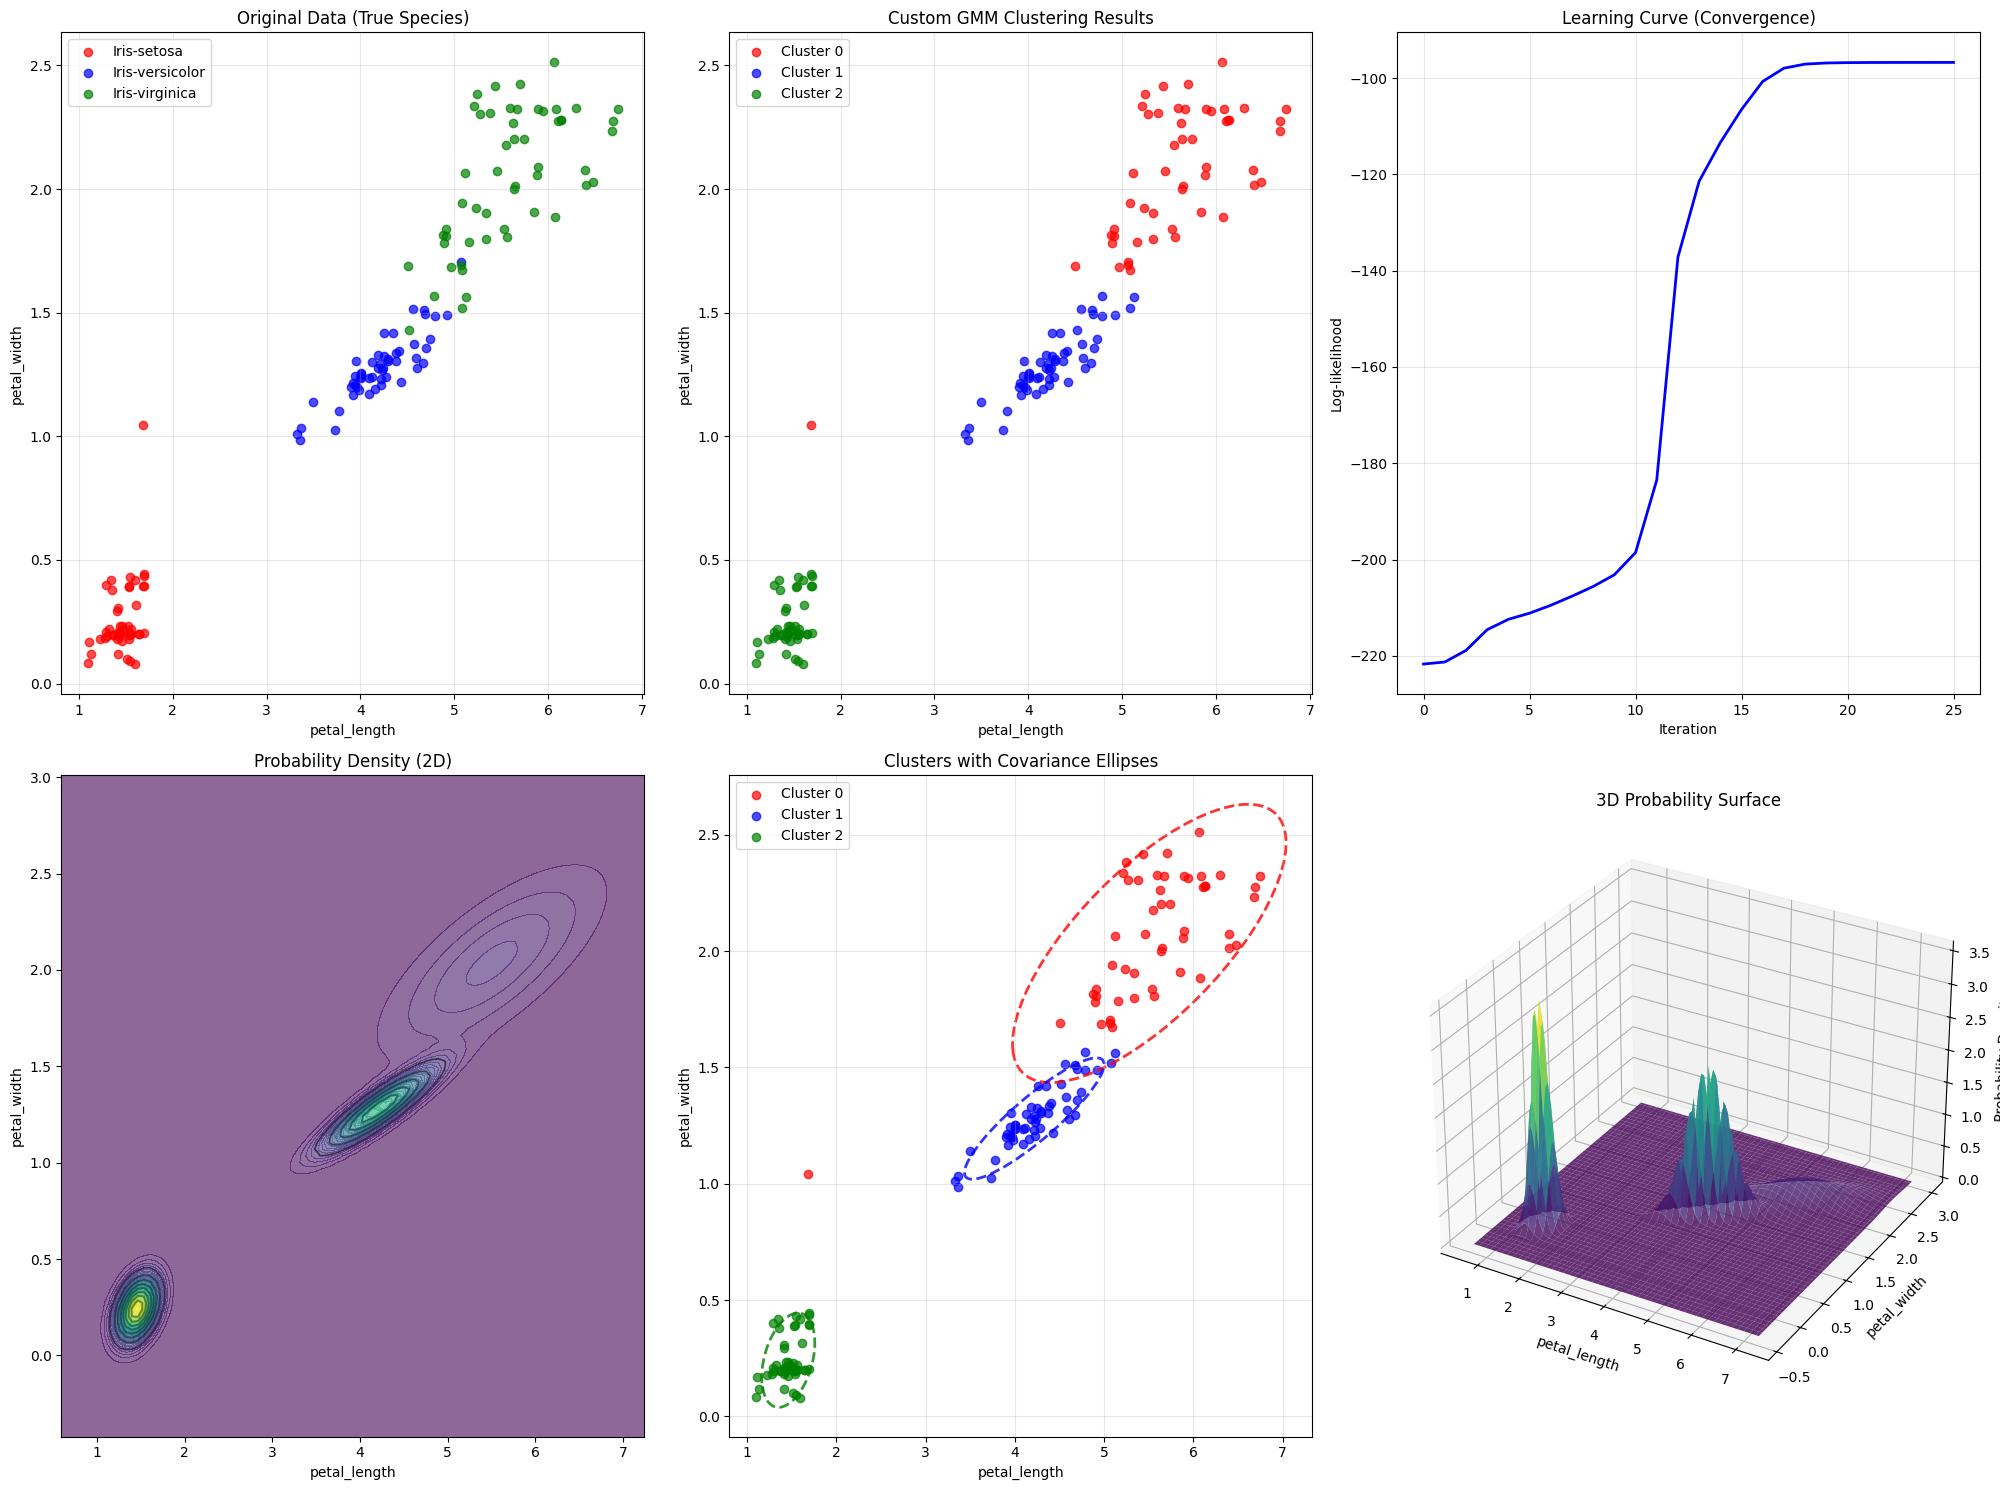


=== Final GMM Parameters ===
Learned Means:
  Component 0: [5.506, 2.033]
  Component 1: [4.217, 1.280]
  Component 2: [1.460, 0.242]

Learned Weights:
  Component 0: 0.344
  Component 1: 0.339
  Component 2: 0.316

Learned Covariances:
  Component 0:
    [[0.587, 0.165]
     [0.165, 0.089]]
  Component 1:
    [[0.153, 0.045]
     [0.045, 0.017]]
  Component 2:
    [[0.022, 0.006]
     [0.006, 0.010]]

=== Comparison with sklearn ===
Custom GMM final log-likelihood: -96.76262971924832

=== True Species vs Custom GMM Clusters ===
Predicted Cluster   0   1   2
True Species                 
Iris-setosa         1   0  49
Iris-versicolor     1  51   0
Iris-virginica     49   4   0


In [24]:
# Load and prepare data
df = pd.read_csv('Iris_dataset_noisy.csv')
X = df[['petal_length', 'petal_width']].values
feature_names = ['petal_length', 'petal_width']

# Create and train custom GMM
print("Training Custom GMM...")
custom_gmm = GMMFromScratch(n_components=3, random_state=42, max_iter=1000)
#custom_gmm.fit(X)
custom_gmm.fit_multi_init(X, n_init=10)

# Get predictions
cluster_labels = custom_gmm.predict(X)
cluster_probs = custom_gmm.predict_proba(X)

# Create visualization
fig = plt.figure(figsize=(20, 15))

# 1. Original data
ax1 = fig.add_subplot(2, 3, 1)
species_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
df['species_num'] = df['species'].map(species_mapping)
colors = ['red', 'blue', 'green']
species_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

for i, (color, species) in enumerate(zip(colors, species_names)):
    mask = df['species_num'] == i
    ax1.scatter(X[mask, 0], X[mask, 1], c=color, alpha=0.7, label=species)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_title('Original Data (True Species)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Custom GMM results
ax2 = fig.add_subplot(2, 3, 2)
for i in range(3):
    mask = cluster_labels == i
    ax2.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')
ax2.set_xlabel(feature_names[0])
ax2.set_ylabel(feature_names[1])
ax2.set_title('Custom GMM Clustering Results')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning curve
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(custom_gmm.log_likelihood_history, 'b-', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log-likelihood')
ax3.set_title('Learning Curve (Convergence)')
ax3.grid(True, alpha=0.3)

# 4. Probability density with contours
ax4 = fig.add_subplot(2, 3, 4)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
log_prob = custom_gmm.score_samples(grid_points)
prob = np.exp(log_prob)
prob = prob.reshape(xx.shape)

contour = ax4.contour(xx, yy, prob, levels=10, colors='black', alpha=0.4)
ax4.contourf(xx, yy, prob, levels=50, cmap='viridis', alpha=0.6)
ax4.set_xlabel(feature_names[0])
ax4.set_ylabel(feature_names[1])
ax4.set_title('Probability Density (2D)')

# 5. Covariance ellipses
ax5 = fig.add_subplot(2, 3, 5)
for i in range(3):
    mask = cluster_labels == i
    ax5.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.7, label=f'Cluster {i}')

# Draw ellipses for each component
for i in range(custom_gmm.n_components):
    mean = custom_gmm.means_[i]
    cov = custom_gmm.covariances_[i]
    
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width = 2 * np.sqrt(eigenvals[0]) * 2
    height = 2 * np.sqrt(eigenvals[1]) * 2
    
    ellipse = Ellipse(mean, width, height, angle=angle, 
                     facecolor='none', edgecolor=colors[i], 
                     linewidth=2, linestyle='--', alpha=0.8)
    ax5.add_patch(ellipse)

ax5.set_xlabel(feature_names[0])
ax5.set_ylabel(feature_names[1])
ax5.set_title('Clusters with Covariance Ellipses')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 3D probability surface
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
surf = ax6.plot_surface(xx, yy, prob, cmap='viridis', alpha=0.8)
ax6.set_xlabel(feature_names[0])
ax6.set_ylabel(feature_names[1])
ax6.set_zlabel('Probability Density')
ax6.set_title('3D Probability Surface')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n=== Final GMM Parameters ===")
print("Learned Means:")
for i, mean in enumerate(custom_gmm.means_):
    print(f"  Component {i}: [{mean[0]:.3f}, {mean[1]:.3f}]")

print("\nLearned Weights:")
for i, weight in enumerate(custom_gmm.weights_):
    print(f"  Component {i}: {weight:.3f}")

print("\nLearned Covariances:")
for i, cov in enumerate(custom_gmm.covariances_):
    print(f"  Component {i}:")
    print(f"    [[{cov[0,0]:.3f}, {cov[0,1]:.3f}]")
    print(f"     [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]")

# Compare with sklearn results

print("\n=== Comparison with sklearn ===")
print("Custom GMM final log-likelihood:", custom_gmm.log_likelihood_history[-1])

# Confusion matrix
comparison = pd.crosstab(df['species'], cluster_labels, 
                        rownames=['True Species'], colnames=['Predicted Cluster'])
print("\n=== True Species vs Custom GMM Clusters ===")
print(comparison)

変なことにはならないようだ。